Introducing kids in the structural lifecycle framework
==========================================

Blundell et. al. (2016)
-------------------------

State space includes:
- age of younghest child
- presense of children, i.e., mother yes/no

Utility includes:
- presense of children interacted with education level
- age of youngest child binned into 0-2, 3-5, 6-10, 11+ (p. 1726)

Other:
- exogenous process of child arriving depends on age and education
- probability of child arriving is set to zero after 43 years of age
- p. 1729 says that child lives with mother until 18 years of age => children above 18 years of age are irrelevant?

Adda, Dustman, Stevens (2017)
-------------------------------------

State space:
- number of children
- age of younghest child

Utility:
- a lot of interactions: husband, employment status, occupation type, etc.
- it matters if one or two children
- age bins: 0-3, 4-6, 7-9

Other:
- having a child is a choice
- variable updated at the beginning of the period, i.e., assumption children arrive at the beginning of the period and have age zero
- unobserved heterogeneity in the taste for children: correlated with ability and taste for leisure
- unobserved heterogeneity in potential infertility, orthogonal to other heterogeneity components

Implementation
-------------------

Goal:
 - most needed! - information on age of younghest child
 
Achive while minimising computational cost!

Challenges:
 - no way to avoide recording age of younghest child
 - no obvious way of decreasing state space size by using bins for ages: age bins do not contain all information necessary to determine child nodes in the backward induction procedure

Potential solution:
 - implement as many constraints as possible in order to reduce number of states, e.g., women over 40 years of age do not get kids any more, we assume women do not get more than 3 kids, etc.
 - optimize code base as much as possible

In [1]:
from soepy.pre_processing.model_processing import read_model_params_init
from soepy.pre_processing.model_processing import read_model_spec_init

In [2]:
model_params_df, model_params = read_model_params_init("toy_model_init_file_04_3types.pkl")
model_spec = read_model_spec_init("model_spec_init.yml", model_params_df)

In [3]:
model_spec

model_specification(num_periods=40, delta=0.98, mu=-0.56, benefits=4.0, educ_max=12, educ_min=10, low_bound=10, middle_bound=11, high_bound=12, seed_sim=102, num_agents_sim=9000, seed_emax=635, num_draws_emax=500, educ_range=3, num_types=3)

In [4]:
model_params_df

value
category      name              
const_wage_eq gamma_0s1    1.925
              gamma_0s2    1.991
              gamma_0s3    1.974
exp_returns   gamma_1s1    0.122
              gamma_1s2    0.157
              gamma_1s3    0.273
exp_accm      g_s1         0.181
              g_s2         0.094
              g_s3         0.128
exp_deprec    delta_s1     0.078
              delta_s2     0.054
              delta_s3     0.070
hetrg_unobs   theta_p1    -0.100
              theta_f1    -0.300
              theta_p2    -0.200
              theta_f2    -0.500
shares        share_1      0.200
              share_2      0.300
sd_wage_shock sigma_1      0.010
              sigma_2      0.192
              sigma_3      0.470
disutil_work  no_kids_f    2.700
              no_kids_p   -0.250
              yes_kids_f   2.100
              yes_kids_p  -0.150
              child_02_f   0.156
              child_02_p  -0.095
              child_35_f   0.093
              child_35_p  -0.067
              child_610_f  0.047
              child_610_p -0.027

In [5]:
is_expected = False

State Space
---------------

In [6]:
import numba

In [7]:
import numpy as np
import pandas as pd

In [8]:
from soepy.shared.shared_constants import MISSING_INT, NUM_CHOICES, INVALID_FLOAT, HOURS
from soepy.solve.solve_auxiliary import pyth_create_state_space

In [9]:
kids_ages = np.arange(-1,12)

Coding of `age_kid` state space variable:
- `-1` - no kid
- `0` - kid was just born. Meaning: in period `t-1` the random process resulted in the woman receiving a child, so she gets a baby in the current period. In period `t-1` is to be read as "in the end of the previous period, after all choices have been made".
- `1+` - age of younghest child

Conventions:
- in most periods a new child can arrive.
- if a new child arrives when there were no children before, in `t-1`, `age_kid` is `-1` and `arrival` = 1, such that in the current period, `age_kid` becomes `0` and `arrival` can again take the values 0 or 1 with respective probabilities.
- if a new child arrives when there already was a child, in `t-1`, `age_kid` is some number between 0 and 10 and `arrival` = 1, such that in the current period, `age_kid` becomes `0` and `arrival` can again take the values 0 or 1 with respective probabilities.

In [10]:
## Todo: Include number of period and age beyond which birth should not be possible any more
# Unit test that probability is zero after that age/number period

@numba.jit(nopython=True)
def pyth_create_state_space(model_spec):
    """Create state space object.

    The state space consists of all admissible combinations of the following components:
    period, years of education, lagged choice, full-time experience (F),
    and part-time experience (P).

    :data:`states` stores the information on states in a tabular format.
    Each row of the table corresponds to one admissible state space point
    and contains the values of the state space components listed above.
    :data:`indexer` is a multidimensional array where each component
    of the state space corresponds to one dimension. The values of the array cells
    index the corresponding state space point in :data:`states`.
    Traversing the state space requires incrementing the indices of :data:`indexer`
    and selecting the corresponding state space point component values in :data:`states`.

    Parameters
    ----------
    model_spec: namedtuple
        Namedtuple containing all fixed parameters describing the model and its
         state space that are relevant for running a simulation.

    Returns
    -------
    states : np.ndarray
        Array with shape (num_states, 5) containing period, years of schooling,
        the lagged choice, the years of experience in part-time, and the
        years of experience in full-time employment.
    indexer : np.ndarray
        A matrix where each dimension represents a characteristic of the state space.
        Switching from one state is possible via incrementing appropriate indices by 1.

    Examples
    --------
    >>> from collections import namedtuple
    >>> model_spec = namedtuple(
    ...     "model_specification", "num_periods educ_range educ_min num_types"
    ... )
    >>> model_spec = model_spec(10, 3, 10, 2)
    >>> NUM_CHOICES = 3
    >>> states, indexer = pyth_create_state_space(
    ...     model_spec
    ... )
    >>> states.shape
    (2220, 6)
    >>> indexer.shape
    (10, 3, 3, 10, 10, 2)
    """
    data = []

    # Array for mapping the state space points (states) to indices
    shape = (
        model_spec.num_periods,
        model_spec.educ_range,
        NUM_CHOICES,
        model_spec.num_periods,
        model_spec.num_periods,
        model_spec.num_types,
        kids_ages.shape[0],
    )

    indexer = np.full(shape, MISSING_INT)

    # Initialize counter for admissible state space points
    i = 0

    # Loop over all periods / all ages
    for period in range(model_spec.num_periods):
        
        # Loop over all types
        for type_ in range(model_spec.num_types):
            
            # Loop over all kids ages that are recorded
            for age_kid in kids_ages:
                # Assumption: 1st kid is born no earlier than in period zero,
                # i.e., in the current setup, no earlier than age 17.
                # Can be relaxed, e.g., we assume that 1st kid can arrive earliest when
                # a woman is 16 years old, the condition becomes:
                # if age_kid > period + 1.
                if age_kid > period:
                    continue
                # Make sure that women above 42 do not get kids
                # For periods corresponding to ages > 42, the `age_kid`
                # state space component can only take values -1, for no child ever,
                # 11, for a child above 11, and 0 - 10 in such a fashion that no
                # birth after 40 years of age is possible.
                if (period > 24 and 0 <= age_kid <= min(period - 25, 10)):
                    continue

                # Loop over all possible initial conditions for education
                for educ_years in range(model_spec.educ_range):

                    # Check if individual has already completed education
                    # and will make a labor supply choice in the period
                    if educ_years > period:
                        continue

                    # Loop over all admissible years of experience accumulated in full-time
                    for exp_f in range(model_spec.num_periods):

                        # Loop over all admissible years of experience accumulated
                        # in part-time
                        for exp_p in range(model_spec.num_periods):

                            # The accumulation of experience cannot exceed time elapsed
                            # since individual entered the model
                            if exp_f + exp_p > period - educ_years:
                                continue

                            # Add an additional entry state
                            # [educ_years + model_params.educ_min, 0, 0, 0]
                            # for individuals who have just completed education
                            # and still have no experience in any occupation.
                            if period == educ_years:

                                # Assign an additional integer count i
                                # for entry state
                                indexer[period, educ_years, 0, 0, 0, type_, age_kid] = i

                                # Record the values of the state space components
                                # for the currently reached entry state
                                row = [
                                    period,
                                    educ_years + model_spec.educ_min,
                                    0,
                                    0,
                                    0,
                                    type_,
                                    age_kid,
                                ]

                                # Update count once more
                                i += 1

                                data.append(row)

                            else:

                                # Loop over the three labor market choices, N, P, F
                                for choice_lagged in range(NUM_CHOICES):

                                    # If individual has only worked full-time in the past,
                                    # she can only have full-time (2) as lagged choice
                                    if (choice_lagged != 2) and (
                                        exp_f == period - educ_years
                                    ):
                                        continue

                                    # If individual has only worked part-time in the past,
                                    # she can only have part-time (1) as lagged choice
                                    if (choice_lagged != 1) and (
                                        exp_p == period - educ_years
                                    ):
                                        continue

                                    # If an individual has never worked full-time,
                                    # she cannot have that lagged activity
                                    if (choice_lagged == 2) and (exp_f == 0):
                                        continue

                                    # If an individual has never worked part-time,
                                    # she cannot have that lagged activity
                                    if (choice_lagged == 1) and (exp_p == 0):
                                        continue

                                    # If an individual has always been employed,
                                    # she cannot have non-employment (0) as lagged choice
                                    if (choice_lagged == 0) and (
                                        exp_f + exp_p == period - educ_years
                                    ):
                                        continue

                                    # Check for duplicate states
                                    if (
                                        indexer[
                                            period,
                                            educ_years,
                                            choice_lagged,
                                            exp_p,
                                            exp_f,
                                            type_,
                                            age_kid,
                                        ]
                                        != MISSING_INT
                                    ):
                                        continue

                                    # Assign the integer count i as an indicator for the
                                    # currently reached admissible state space point
                                    indexer[
                                        period,
                                        educ_years,
                                        choice_lagged,
                                        exp_p,
                                        exp_f,
                                        type_,
                                        age_kid,
                                    ] = i

                                    # Update count
                                    i += 1

                                    # Record the values of the state space components
                                    # for the currently reached admissible state space point
                                    row = [
                                        period,
                                        educ_years + model_spec.educ_min,
                                        choice_lagged,
                                        exp_p,
                                        exp_f,
                                        type_,
                                        age_kid,
                                    ]

                                    data.append(row)

        states = np.array(data)

    # Return function output
    return states, indexer

In [11]:
states, indexer = pyth_create_state_space(model_spec)

In [12]:
states.shape

(1772145, 7)

In [ ]:
%timeit pyth_create_state_space(model_spec)

Construct covariates
-------------------------

In [13]:
def construct_covariates(states, model_spec):
    """Construct a matrix of all the covariates
    that depend only on the state space.

    Parameters
    ---------
    states : np.ndarray
        Array with shape (num_states, 5) containing period, years of education,
        the lagged choice, years of experience in part-time and in full-time
         employment of the agent.

    Returns
    -------
    covariates : np.ndarray
        Array with shape (num_states, number of covariates) containing all additional
        covariates, which depend only on the state space information.

    """
    
    # Level of education derived from years of education
    educ_years = pd.Series(states[:, 1])
    educ_level = pd.cut(
        educ_years,
        bins=[0, model_spec.low_bound, model_spec.middle_bound, model_spec.high_bound],
        labels=[0, 1, 2],
    ).to_numpy()
    
    # Bins of age of younghest child based on kids age
    # bin 0 corresponds to no kid, remaining bins as in Blundell
    # 0-2, 3-5, 6-10, 11+
    age_kid = pd.Series(states[:, 6])
    bins = pd.cut(
        age_kid,
        bins = [-2, -1, 2, 5, 10, 11],
        labels = [0, 1, 2, 3, 4],
    ).to_numpy()
    
    covariates = np.column_stack(
        (
            educ_level,
            bins
        )
    )

    return covariates

In [14]:
covariates = construct_covariates(states, model_spec)

In [15]:
covariates.shape

(1772145, 2)

Calculate utility
------------------

In [16]:
def calculate_utility_components(
    model_params, model_spec, states, covariates, is_expected
):
    """Calculate utility components for all choices given state, period, and shocks.

    Parameters
    ----------
    model_params : namedtuple
        Contains all parameters of the model including information on dimensions
        (number of periods, agents, random draws, etc.) and coefficients to be
        estimated.
    states : np.ndarray
        Array with shape (num_states, 5) containing period, years of schooling,
        the lagged choice, the years of experience in part-time, and the
        years of experience in full-time employment.
    covariates: np.ndarray
        Array with shape (num_states, number of covariates) containing all additional
        covariates, which depend only on the state space information.
    is_expected: bool
        A boolean indicator that differentiates between the human capital accumulation
        process that agents expect (is_expected = True) and that the market generates
        (is_expected = False)

    Returns
    -------
    log_wage_systematic : array
        One dimensional array with length num_states containing the part of the wages
        at the respective state space point that do not depend on the agent's choice,
        nor on the random shock.
    non_consumption_utilities : np.ndarray
        Array of dimension (num_states, num_choices) containing the utility
        contribution of non-pecuniary factors.

    """
    log_wage_systematic = calculate_log_wage_systematic(
        model_params, states, covariates, is_expected
    )

    non_consumption_utility = calculate_non_consumption_utility(
        model_params, model_spec, states, covariates
    )

    return log_wage_systematic, non_consumption_utility


def calculate_log_wage_systematic(model_params, states, covariates, is_expected):
    """Calculate systematic wages, i.e., wages net of shock, for all states."""

    exp_p, exp_f = states[:, 3], states[:, 4]
    educ_level = covariates[:, 0]

    # Construct wage components
    gamma_0s = np.array(model_params.gamma_0s)[educ_level]
    gamma_1s = np.array(model_params.gamma_1s)[educ_level]

    if is_expected:
        period_exp_sum = 0.5 * exp_p + exp_f
    else:
        period_exp_sum = exp_p * np.array(model_params.g_s)[educ_level] + exp_f

    depreciation = 1 - np.array(model_params.delta_s)[educ_level]

    # Calculate wage in the given state
    period_exp_total = period_exp_sum * depreciation + 1
    returns_to_exp = gamma_1s * np.log(period_exp_total)
    log_wage_systematic = gamma_0s + returns_to_exp

    return log_wage_systematic


def calculate_non_consumption_utility(model_params, model_spec, states, covariates):
    """Calculate non-pecuniary utility contribution."""

    # Old
    #non_consumption_utility = np.full(
    #    (states.shape[0], NUM_CHOICES), [0, model_params.const_p, model_params.const_f]
    #)
    
    # New:
    # Since we plan to include all types of mutully exclusive combinations of presence
    # of children and their ages, we can no longer accomodate a constant
    non_consumption_utility = np.full(
        (states.shape[0], NUM_CHOICES), [0.00, 0.00, 0.00]
    )
    
    # Type contribution
    # TODO: Can I get rid of the 1st zero everywhere?
    for i in range(1, model_spec.num_types):
        non_consumption_utility[np.where(states[:, 5] == i)] += [
            0,
            model_params.theta_p[i - 1],
            model_params.theta_f[i - 1],
        ]
    
    # Children constribution 
    ## TODO: Introduce as free paramters in model spec
    
    # No children
    non_consumption_utility[np.where(covariates[:, 1] == 0)] += [
        0,                   # non-employed
        2.700 + (-0.250),    # part-time alpha_f_no_kids + alpha_p_no_kids
        2.700,               # full-time alpha_f_no_kids
    ]
    
    # Children present:
    non_consumption_utility[np.where(covariates[:, 1] != 0)] += [
        0,
        2.100 + (-0.150),
        2.100,
    ]
    
    # Contribution child aged 0-2:
    non_consumption_utility[np.where(covariates[:, 1] == 1)] += [
        0,
        0.156 + (-0.095),
        0.156,
    ]
    
    # Contribution child aged 3-5:
    non_consumption_utility[np.where(covariates[:, 1] == 2)] += [
        0,
        0.093 + (-0.067),
        0.093,
    ]
        
        # Contribution child aged 6-10:
    non_consumption_utility[np.where(covariates[:, 1] == 3)] += [
        0,
        0.047 + (-0.027),
        0.047,
    ]
    
    non_consumption_utility = np.exp(non_consumption_utility)

    return non_consumption_utility


In [17]:
log_wage_systematic, non_consumption_utilities = calculate_utility_components(
    model_params, model_spec, states, covariates, is_expected
)

In [18]:
non_consumption_utilities

array([[ 1.        , 11.58834672, 14.87973172],
       [ 1.        ,  7.4707844 ,  9.54483337],
       [ 1.        , 10.48556972, 11.02317638],
       ...,
       [ 1.        ,  5.75460268,  4.95303242],
       [ 1.        ,  5.75460268,  4.95303242],
       [ 1.        ,  5.75460268,  4.95303242]])

Create draws
----------------

Draws for emax

In [19]:
from soepy.shared.shared_auxiliary import draw_disturbances

In [20]:
attrs_spec = ["seed_emax", "num_periods", "num_draws_emax"]
draws_emax = draw_disturbances(
    *[getattr(model_spec, attr) for attr in attrs_spec], model_params
)

Draws for exogenous process kids

In [21]:
prob_child_values = [
    0.001, #0 = 16 years of age
    0.002, 
    0.004,
    0.008,
    0.011,
    0.015,
    0.018,
    0.022,
    0.027,
    0.034,
    0.042, #10 = 26 years of age
    0.054, 
    0.061,
    0.070,
    0.074,
    0.077,
    0.074,
    0.071,
    0.066,
    0.061,
    0.054, #20 = 36 years of age
    0.045, 
    0.034,
    0.027,
    0.020, #24 = 40 years of age
]

In [22]:
# Probability to have child for each age
prob_child = np.full(model_spec.num_periods, 0.00)
prob_child[0:25] += prob_child_values

Child update rule

In [23]:
# Idea: Determine age of the child in the child nodes outside of the get_continuation_values function
# since ages are a deterministic function of current age of child and the child_arriving variable

# Child arrives is equivalent to new child age = 0
# If no child arrives we need to specify an update rule
# Age stays at -1 if no kids so far
child_age_update_rule = np.full(states.shape[0], -1)
# Age increases by one, if there is a kid
child_age_update_rule[np.where(covariates[:, 1] != 0)] = states[np.where(covariates[:, 1] != 0)][:, 6] + 1
# Age does not exceed 11.
child_age_update_rule[child_age_update_rule > 11] = 11

Backward induction
------------------------

In [24]:
def pyth_backward_induction(
    model_spec, 
    states, 
    indexer, 
    log_wage_systematic, 
    non_consumption_utilities, 
    draws, 
    child_age_update_rule, 
    prob_child,
):
    """Get expected maximum value function at every state space point.
    Backward induction is performed all at once for all states in a given period.
    The function loops through each period. The included construct_emax function
    implicitly loops through all states in the period currently reached by the
    parent loop.

    Parameters
    ----------
    model_spec : namedtuple
        Contains all fixed parameters of the model including information on dimensions
        such as number of periods, agents, random draws, etc.
    states : np.ndarray
        Array with shape (num_states, 5) containing period, years of schooling,
        the lagged choice, the years of experience in part-time, and the
        years of experience in full-time employment.
    indexer : np.ndarray
        Array where each dimension represents a componenet of the state space.
        :data:`states[k]` returns the values of the state space components
        at state :data:`k`. Indexing :data:`indexer` by the same state space
        component values returns :data:`k`.
    log_wage_systematic : np.array
        One dimensional array with length num_states containing the part of the wages
        at the respective state space point that do not depend on the agent's choice,
        nor on the random shock.
    non_consumption_utilities : np.ndarray
        Array of dimension (num_states, num_choices) containing the utility
        contribution of non-pecuniary factors.

    Returns
    -------
    emaxs : np.ndarray
        An array of dimension (num_states, num choices + 1). The object's rows contain
        the continuation values of each choice at the specific state space points
        as its first elements. The last row element corresponds to the maximum
        expected value function of the state.
    """

    emaxs = np.zeros((states.shape[0], NUM_CHOICES + 1))

    # Loop backwards over all periods
    for period in reversed(range(model_spec.num_periods)):

        # Extract period information
        # States
        states_period = states[np.where(states[:, 0] == period)]

        # Info on updated age of child
        child_age_update_rule_period = child_age_update_rule[np.where(states[:, 0] == period)]
        
        # Probability that a child arives
        prob_child_period = prob_child[period]
        
        log_wage_systematic_period = log_wage_systematic[states[:, 0] == period]
        non_consumption_utilities_period = non_consumption_utilities[
            states[:, 0] == period
        ]

        # Continuation value calculation not performed for last period
        # since continuation values are known to be zero
        if period == model_spec.num_periods - 1:
            pass
        else:

            # Fill first block of elements in emaxs for the current period
            # corresponding to the continuation values
            emaxs = get_continuation_values(
                model_spec,
                states_period,
                indexer,
                emaxs,
                child_age_update_rule_period,
                prob_child_period,
            )

        # Extract current period information for current loop calculation
        emaxs_period = emaxs[np.where(states[:, 0] == period)]

        # Calculate emax for current period reached by the loop
        emax_period = construct_emax(
            model_spec.delta,
            log_wage_systematic_period,
            non_consumption_utilities_period,
            draws[period],
            emaxs_period[:, :3],
            HOURS,
            model_spec.mu,
            model_spec.benefits,
        )
        emaxs_period[:, 3] = emax_period
        emaxs[np.where(states[:, 0] == period)] = emaxs_period

    return emaxs


@numba.njit(nogil=True)
def get_continuation_values(model_spec, states_subset, indexer, emaxs, child_age_update_rule_period, prob_child_period):
    """Obtain continuation values for each of the choices at each state
    of the period currently reached by the parent loop.

    This function takes a parent node and looks up the continuation values
    of each of the available choices. It takes the entire block of
    data:`emaxs` corresponding to the period and fills in the first block
    of elements corresponding to the continuation values.
    The continuation value of each choice is the expected maximum value
    function of the next period's state if the particular choice was
    taken this period. The expected maximum value function values are
    contained as the last element of the data:`emaxs` row of next
    period's state.

    Warning
    -------
    This function must be extremely performant as the lookup is done for each state in a
    state space (except for states in the last period) for each evaluation of the
    optimization of parameters.
    """
    for i in range(states_subset.shape[0]):
        
        # Unpack parent state and get index
        period, educ_years, choice_lagged, exp_p, exp_f, type_, age_kid = states_subset[i]
        k_parent = indexer[
            period, educ_years - model_spec.educ_min, choice_lagged, exp_p, exp_f, type_, age_kid,
        ]
        
        # TODO: Observe that probability of having a child for last periods is zero
        # One can skip some of the calculations for these periods. How to implement?
        
        # TODO: Can I not actually use two for loops here: loop over states and then over choices
        
        # Choice: Non-employment
        # Case no child arrives
        k_0 = indexer[
            period + 1, 
            educ_years - model_spec.educ_min, 
            0, 
            exp_p, 
            exp_f, 
            type_, 
            child_age_update_rule_period[i],
        ]
        
        # Case: child arrives
        k_1 = indexer[
            period + 1, 
            educ_years - model_spec.educ_min, 
            0, 
            exp_p, 
            exp_f, 
            type_, 
            0,
        ]
        
        emaxs[k_parent, 0] = (1 - prob_child_period)*emaxs[k_0, 3] + prob_child_period*emaxs[k_1, 3]

        # Choice: Part-time
        k_0 = indexer[
            period + 1, 
            educ_years - model_spec.educ_min, 
            1, 
            exp_p + 1, 
            exp_f, 
            type_, 
            child_age_update_rule_period[i],
        ]
        
        k_1 = indexer[
            period + 1, 
            educ_years - model_spec.educ_min, 
            1, 
            exp_p + 1, 
            exp_f, 
            type_, 
            0,
        ]
            
        emaxs[k_parent, 1] = (1 - prob_child_period)*emaxs[k_0, 3] + prob_child_period*emaxs[k_1, 3]

        # Choice: Full-time
        k_0 = indexer[
            period + 1, 
            educ_years - model_spec.educ_min, 
            2, 
            exp_p, 
            exp_f + 1, 
            type_, 
            child_age_update_rule_period[i],
        ]
        
        k_1 = indexer[
            period + 1, 
            educ_years - model_spec.educ_min, 
            2, 
            exp_p, 
            exp_f + 1, 
            type_, 
            0,
        ]
        
        emaxs[k_parent, 2] = (1 - prob_child_period)*emaxs[k_0, 3] + prob_child_period*emaxs[k_1, 3]

    return emaxs


@numba.njit
def _get_max_aggregated_utilities(
    delta,
    log_wage_systematic,
    non_consumption_utilities,
    draws,
    emaxs,
    hours,
    mu,
    benefits,
):

    current_max_value_function = INVALID_FLOAT

    for j in range(NUM_CHOICES):

        wage = np.exp(log_wage_systematic + draws[j])

        if j == 0:
            consumption_utility = benefits ** mu / mu
        else:
            consumption_utility = (hours[j] * wage) ** mu / mu

        value_function_choice = (
            consumption_utility * non_consumption_utilities[j] + delta * emaxs[j]
        )

        if value_function_choice > current_max_value_function:
            current_max_value_function = value_function_choice

    return current_max_value_function


@numba.guvectorize(
    ["f8, f8, f8[:], f8[:, :], f8[:], f8[:], f8, f8, f8[:]"],
    "(), (), (n_choices), (n_draws, n_choices), (n_choices), (n_choices), (), () -> ()",
    nopython=True,
    target="parallel",
)
def construct_emax(
    delta,
    log_wage_systematic,
    non_consumption_utilities,
    draws,
    emaxs,
    hours,
    mu,
    benefits,
    emax,
):
    """Simulate expected maximum utility for a given distribution of the unobservables.

    The function calculates the maximum expected value function over the distribution of
    the error term at each state space point in the period currently reached by the
    parent loop. The expectation calculation is performed via `Monte Carlo
    integration`. The goal is to approximate an integral by evaluating the integrand at
    randomly chosen points. In this setting, one wants to approximate the expected
    maximum utility of a given state.

    Parameters
    ----------
    delta : int
        Dynamic discount factor.
    log_wage_systematic : array
        One dimensional array with length num_states containing the part of the wages
        at the respective state space point that do not depend on the agent's choice,
        nor on the random shock.
    non_consumption_utilities : np.ndarray
        Array of dimension (num_states, num_choices) containing the utility
        contribution of non-pecuniary factors.
    draws : np.ndarray
        Array of dimension (num_periods, num_choices, num_draws). Randomly drawn
        realisations of the error term used to integrate out the distribution of
        the error term.
    emaxs : np.ndarray
        An array of dimension (num. states in period, num choices + 1).
        The object's rows contain the continuation values of each choice at the specific
        state space points as its first elements. The last row element corresponds
        to the maximum expected value function of the state. This column is
        full of zeros for the input object.
    hours : np.array
        Array of constants, corresponding to the working hours associated with
        each employment choice.
    mu : int
        Constant governing the degree of risk aversion and inter-temporal
        substitution in the model.
    benefits : int
        Constant level of hourly income received in case of choice N,
        non-employment.

    Returns
    -------
    emax : np.array
        Expected maximum value function of the current state space point.
        Array of lentgh number of states in the current period. The vector
        corresponds to the second block of values in the data:`emaxs` object.

    .. _Monte Carlo integration:
        https://en.wikipedia.org/wiki/Monte_Carlo_integration

    """
    num_draws = draws.shape[0]

    emax[0] = 0.0

    for i in range(num_draws):

        max_total_utility = _get_max_aggregated_utilities(
            delta,
            log_wage_systematic,
            non_consumption_utilities,
            draws[i],
            emaxs,
            hours,
            mu,
            benefits,
        )

        emax[0] += max_total_utility

    emax[0] /= num_draws

In [25]:
# Backward induction is now super super slow
emaxs = pyth_backward_induction(
    model_spec,
    states,
    indexer,
    log_wage_systematic,
    non_consumption_utilities,
    draws_emax,
    child_age_update_rule,
    prob_child,
)

In [ ]:
%timeit pyth_backward_induction(model_spec, states, indexer, log_wage_systematic, non_consumption_utilities, draws_emax, child_age_update_rule, prob_child)

In [26]:
from soepy.shared.shared_constants import HOURS

DATA_LABLES_SIM = [
    "Identifier",
    "Period",
    "Years_of_Education",
    "Lagged_Choice",
    "Experience_Part_Time",
    "Experience_Full_Time",
    "Type",
    "Age_Younghest_Child",
    "Choice",
    "Log_Systematic_Wage",
    "Period_Wage_N",
    "Period_Wage_P",
    "Period_Wage_F",
    "Non_Consumption_Utility_N",
    "Non_Consumption_Utility_P",
    "Non_Consumption_Utility_F",
    "Flow_Utility_N",
    "Flow_Utility_P",
    "Flow_Utility_F",
    "Continuation_Value_N",
    "Continuation_Value_P",
    "Continuation_Value_F",
    "Value_Function_N",
    "Value_Function_P",
    "Value_Function_F",
]

DATA_FORMATS_SIM = {
    key: (np.int if key in DATA_LABLES_SIM[:8] else np.float) for key in DATA_LABLES_SIM
}

## TODO: introduce probability that the child is born

def pyth_simulate(
    model_params, model_spec, states, indexer, emaxs, covariates, is_expected, child_age_update_rule, prob_child,
):
    """Simulate agent experiences."""

    # Draw random initial conditions
    educ_years = list(range(model_spec.educ_min, model_spec.educ_max + 1))
    np.random.seed(model_spec.seed_sim)
    initial_educ_years = np.random.choice(educ_years, model_spec.num_agents_sim)

    # Draw random type
    type_ = np.random.choice(
        list(np.arange(model_spec.num_types)),
        model_spec.num_agents_sim,
        p=model_params.type_shares,
    )
    
    # Draw shocks
    attrs_spec = ["seed_sim", "num_periods", "num_agents_sim"]
    draws_sim = draw_disturbances(
        *[getattr(model_spec, attr) for attr in attrs_spec], model_params
    )

    # Calculate utility components
    log_wage_systematic, non_consumption_utilities = calculate_utility_components(
        model_params, model_spec, states, covariates, is_expected
    )

    # Determine initial states according to initial conditions
    initial_states = pd.DataFrame(
        np.column_stack(
            (
                np.arange(model_spec.num_agents_sim),
                initial_educ_years - model_spec.educ_min,
                initial_educ_years,
                np.zeros((model_spec.num_agents_sim, 3)),
                type_,
            )
        ),
        columns=DATA_LABLES_SIM[:7],
    ).astype(np.int)

    data = []

    # Loop over all periods
    for period in range(model_spec.num_periods):

        initial_states_in_period = initial_states.loc[
            initial_states.Years_of_Education.eq(period + model_spec.educ_min)
        ].to_numpy()
        
        # Draw indicator of child appearing in the first period
        kids_init_draw = np.random.binomial(
        size = initial_states_in_period.shape[0],
        n = 1,
        p = prob_child[period],
        )

        # Convert to init age of child
        child_init_age = np.where(kids_init_draw == 0, -1, 0)
        # Add column to state space
        initial_states_in_period = np.c_[initial_states_in_period, child_init_age]

        # Get all agents in the period.
        if period == 0:
            current_states = initial_states_in_period
        else:
            current_states = np.vstack((current_states, initial_states_in_period))

        idx = indexer[
            current_states[:, 1],
            current_states[:, 2] - model_spec.educ_min,
            current_states[:, 3],
            current_states[:, 4],
            current_states[:, 5],
            current_states[:, 6],
            current_states[:, 7],
        ]

        # Extract corresponding utilities
        current_log_wage_systematic = log_wage_systematic[idx]
        current_non_consumption_utilities = non_consumption_utilities[idx]

        current_wages = np.exp(
            current_log_wage_systematic.reshape(-1, 1)
            + draws_sim[period, current_states[:, 0]]
        )
        current_wages[:, 0] = model_spec.benefits

        # Calculate total values for all choices
        flow_utilities = np.full((current_states.shape[0], 3), np.nan)

        flow_utilities[:, :1] = (
            model_spec.benefits ** model_spec.mu
            / model_spec.mu
            * current_non_consumption_utilities[:, :1]
        )
        flow_utilities[:, 1:] = (
            (HOURS[1:] * current_wages[:, 1:]) ** model_spec.mu
            / model_spec.mu
            * current_non_consumption_utilities[:, 1:]
        )

        # Extract continuation values for all choices
        continuation_values = emaxs[idx, :3]

        value_functions = flow_utilities + model_spec.delta * continuation_values

        # Determine choice as option with highest choice specific value function
        choice = np.argmax(value_functions, axis=1)
        
        if period <= 24:
            # Update current states according to expogenous processes 
            # Relate to child age updating
            kids_current_draw = np.random.binomial(
            size = current_states.shape[0],
            n = 1,
            p = prob_child[period + 1],
            )

            # Convert to age of child according to age update rule
            child_current_age = np.where(kids_current_draw == 0, child_age_update_rule[idx], 0)   
        else:
            child_current_age = child_age_update_rule[idx]

        # Record period experiences
        rows = np.column_stack(
            (
                current_states.copy(),
                choice,
                current_log_wage_systematic,
                current_wages,
                current_non_consumption_utilities,
                flow_utilities,
                continuation_values,
                value_functions,
            )
        )

        data.append(rows)

        # Update current states according to choice
        current_states[:, 1] += 1
        current_states[:, 3] = choice
        current_states[:, 4] = np.where(
            choice == 1, current_states[:, 4] + 1, current_states[:, 4]
        )
        current_states[:, 5] = np.where(
            choice == 2, current_states[:, 5] + 1, current_states[:, 5]
        )
        current_states[:, 7] = child_current_age

    dataset = (
        pd.DataFrame(np.vstack(data), columns=DATA_LABLES_SIM)
        .astype(DATA_FORMATS_SIM)
        .set_index(["Identifier", "Period"], drop=False)
    )

    # Fill gaps in history with NaNs.
    index = pd.MultiIndex.from_product(
        [range(model_spec.num_agents_sim), range(model_spec.num_periods)]
    )
    dataset = dataset.reindex(index)

    return dataset


In [27]:
dataset_sim = pyth_simulate(model_params, model_spec, states, indexer, emaxs, covariates, is_expected, child_age_update_rule, prob_child)

In [28]:
dataset_sim.head()

Identifier  Period  Years_of_Education  Lagged_Choice  \
0 0         0.0     0.0                10.0            0.0   
  1         0.0     1.0                10.0            2.0   
  2         0.0     2.0                10.0            0.0   
  3         0.0     3.0                10.0            2.0   
  4         0.0     4.0                10.0            0.0   

     Experience_Part_Time  Experience_Full_Time  Type  Age_Younghest_Child  \
0 0                   0.0                   0.0   1.0                 -1.0   
  1                   0.0                   1.0   1.0                 -1.0   
  2                   0.0                   1.0   1.0                 -1.0   
  3                   0.0                   2.0   1.0                 -1.0   
  4                   0.0                   2.0   1.0                 -1.0   

     Choice  Log_Systematic_Wage  ...  Non_Consumption_Utility_F  \
0 0     2.0             1.925000  ...                  11.023176   
  1     0.0             2.004711  ...                  11.023176   
  2     2.0             2.004711  ...                  11.023176   
  3     0.0             2.052516  ...                  11.023176   
  4     0.0             2.052516  ...                  11.023176   

     Flow_Utility_N  Flow_Utility_P  Flow_Utility_F  Continuation_Value_N  \
0 0       -0.821596       -1.143006       -0.563118            -16.842099   
  1       -0.821596       -1.243616       -0.984259            -16.360825   
  2       -0.821596       -1.135373       -0.789829            -15.987231   
  3       -0.821596       -1.172204       -1.115185            -15.510060   
  4       -0.821596       -1.224477       -1.286852            -15.143852   

     Continuation_Value_P  Continuation_Value_F  Value_Function_N  \
0 0            -16.816171            -16.717439        -17.326853   
  1            -16.342000            -16.265249        -16.855204   
  2            -15.968576            -15.892551        -16.489083   
  3            -15.494884            -15.431349        -16.021455   
  4            -15.128794            -15.065763        -15.662571   

     Value_Function_P  Value_Function_F  
0 0        -17.622854        -16.946209  
  1        -17.258776        -16.924203  
  2        -16.784578        -16.364529  
  3        -16.357190        -16.237907  
  4        -16.050695        -16.051300  

[5 rows x 25 columns]

In [29]:
def get_moments(data):
    # Pre_process data frame

    # Determine the education level given years of experience
    data["Educ_Level"] = 0
    data.loc[
        (data["Years_of_Education"] >= 10) & (data["Years_of_Education"] < 12),
        "Educ_Level",
    ] = 0
    data.loc[
        (data["Years_of_Education"] >= 12) & (data["Years_of_Education"] < 16),
        "Educ_Level",
    ] = 1
    data.loc[data["Years_of_Education"] >= 16, "Educ_Level"] = 2

    # Determine the observed wage given period choice
    data["Wage_Observed"] = 0
    data.loc[data["Choice"] == 0, "Wage_Observed"] = data.loc[
        data["Choice"] == 0, "Period_Wage_N"
    ]
    data.loc[data["Choice"] == 1, "Wage_Observed"] = data.loc[
        data["Choice"] == 1, "Period_Wage_P"
    ]
    data.loc[data["Choice"] == 2, "Wage_Observed"] = data.loc[
        data["Choice"] == 2, "Period_Wage_F"
    ]

    # Calculate moments

    # Initialize moments dictionary
    moments = dict()

    # Store moments in groups as nested dictionary
    for group in ["Wage_Distribution", "Choice_Probability"]:
        moments[group] = dict()

    # Compute unconditional moments of the wage distribution
    info = data.groupby(["Period"])["Wage_Observed"].describe().to_dict()

    # Save mean and standard deviation of wages for each period
    # to Wage Distribution section of the moments dictionary
    for period in range(NUM_PERIODS):  # TODO: Remove hard coded number
        moments["Wage_Distribution"][period] = []
        try:
            for label in ["mean", "std"]:
                moments["Wage_Distribution"][period].append(info[label][period])
        except KeyError:
            for i in range(2):
                moments["Wage_Distribution"][period].append(0.0)

    # Compute unconditional moments of the choice probabilities
    info = data.groupby(["Period"])["Choice"].value_counts(normalize=True).to_dict()

    for period in range(NUM_PERIODS):  # TODO: Remove hard coded number
        moments["Choice_Probability"][period] = []
        for choice in range(3):
            try:
                stat = info[(period, choice)]
            except KeyError:
                stat = 0.00
            moments["Choice_Probability"][period].append(stat)

    return moments


In [34]:
NUM_PERIODS = 30

# Get simulated moments
data_sim = dataset_sim
moments_sim = get_moments(data_sim)

In [35]:
import pickle

# Get observed moments
with open("moments_obs.pkl", "rb") as f:
    moments_obs = pickle.load(f)

# Plot choice probabilities
lables = [
    "Non-employment choice rates",
    "Part-time choice rates",
    "Full-time choice rates",
]

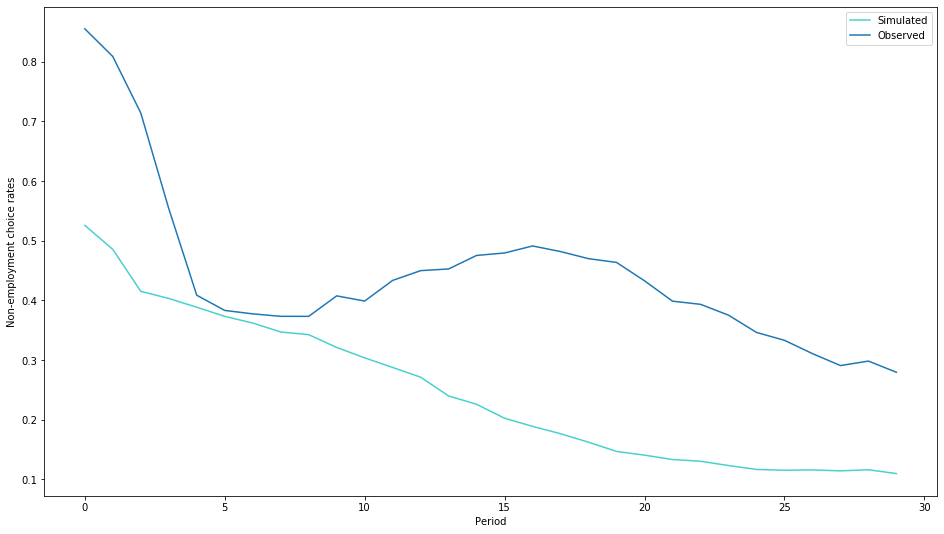

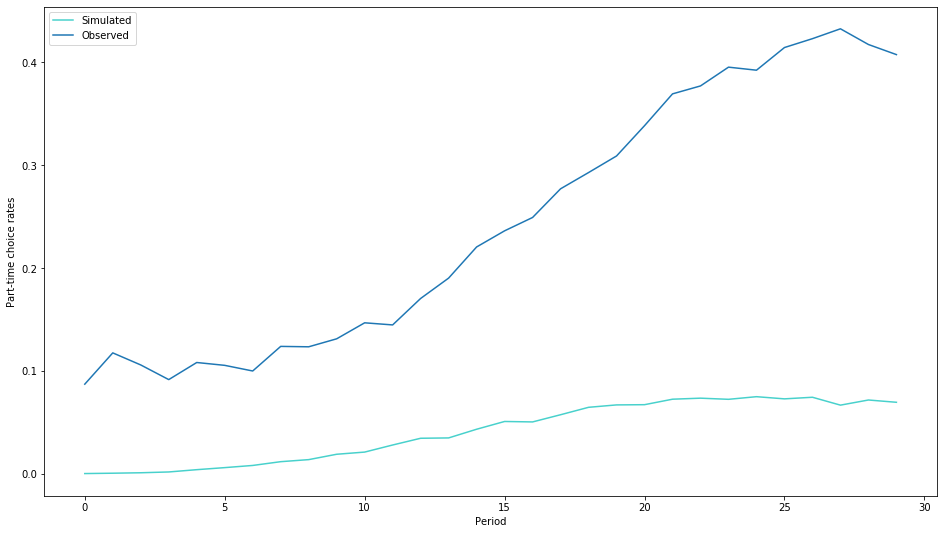

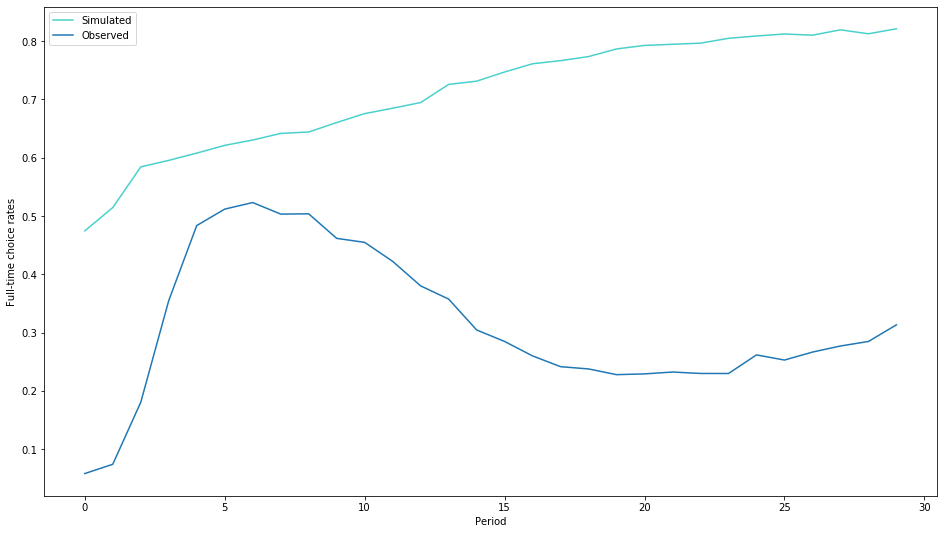

In [37]:
import matplotlib.pyplot as plt

for choice in range(3):

        obs_choice_prob = []
        for _, value in moments_obs["Choice_Probability"].items():
            temp = [_, value]
            obs_choice_prob.append(temp[1][choice])

        sim_choice_prob = []
        for _, value in moments_sim["Choice_Probability"].items():
            temp = [_, value]
            sim_choice_prob.append(temp[1][choice])

        x = np.arange(30)

        # Start plot
        ax = plt.figure(figsize=[16, 9]).add_subplot(111)
        ax.set_ylabel(lables[choice])
        ax.set_xlabel("Period")

        plt.plot(x, sim_choice_prob, color="mediumturquoise")
        plt.plot(x, obs_choice_prob)

        ax.legend(["Simulated", "Observed"])